# Additional dataset
The additional dataset that we chose is the [Statlog (German Credit Data)](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data). Why is it chosen? <br>
It has many important data types for classification problems, including integer, binary, and categorical data. <br>
The only drawback of this dataset is its variable name, which is Attribute1, Attribute2, ..., Attribute21, class (target). The description of each variable will be stated in our report because it is very long.

# Table of contents
1. Install scikit-learn & required libraries
2. Preparing and Encoding the data <br>
   2.1 Download the datasets <br>
   2.2 One-hot Encoding and Binary Encoding <br>
3. Define functions to split train/test, build the decision tree, and draw the confustion matrix <br>
   3.1 Spliting the train/test data with a test ratio <br>
   3.2 Building & visualizing decision tree with training models <br>
   3.3 Confusion matrix and classification report <br>
4. 40/60 ratio for train/test set
5. 60/40 ratio for train/test set
6. 80/20 ratio for train/test set
7. 90/10 ratio for train/test set
8. Correlation between max depth and accuracy of the decision tree on the 80/20 set.<br>
   8.1 Charts showing correlation between max depth and accuracy

# 1. Install scikit-learn & required libraries
This project require numpy, pandas, matplotlib,... and scikit-learn be installed. Run the following code to install the requirements.

In [1]:
!python -m pip install -U scikit-learn
!python -m pip install matplotlib
!python -m pip install ucimlrepo
!python -m pip install pydotplus

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus

from ucimlrepo import fetch_ucirepo
from sklearn import tree
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from io import StringIO
from pydotplus import graph_from_dot_data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# 2. Preparing and Encoding the data

# 2.1 Download the datasets

In [98]:
# fetch dataset
statlog_german_credit = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
features = statlog_german_credit.data.features
targets = statlog_german_credit.data.targets

In [112]:
# Check the data types for all data to know how the 
# machine is looking at the variables currently.
# From here, we will know what data to be encoded properly.
features.dtypes

# targets['class'].value_counts()

Attribute1     object
Attribute2      int64
Attribute3     object
Attribute4     object
Attribute5      int64
Attribute6     object
Attribute7     object
Attribute8      int64
Attribute9     object
Attribute10    object
Attribute11     int64
Attribute12    object
Attribute13     int64
Attribute14    object
Attribute15    object
Attribute16     int64
Attribute17    object
Attribute18     int64
Attribute19    object
Attribute20    object
dtype: object

# 2.2 One-hot Encoding and Binary Encoding
Encode the categorical data types using one-hot encoding. For example: a variable has three values: high, low, med.<br>
So if an example has buying = low, then the data is displayed as (high = False, low = True, med = False)

In [100]:
features_encoded = pd.get_dummies(features, columns=['Attribute1', 'Attribute3', 'Attribute4', 'Attribute6', 'Attribute7',
                                                     'Attribute9', 'Attribute10', 'Attribute12', 'Attribute14', 
                                                     'Attribute15', 'Attribute17'])
features_encoded.head()

,Attribute2,Attribute5,Attribute8,Attribute11,Attribute13,Attribute16,Attribute18,Attribute19,Attribute20,Attribute1_A11,...,Attribute14_A141,Attribute14_A142,Attribute14_A143,Attribute15_A151,Attribute15_A152,Attribute15_A153,Attribute17_A171,Attribute17_A172,Attribute17_A173,Attribute17_A174
0,6,1169,4,4,67,2,1,A192,A201,True,...,False,False,True,False,True,False,False,False,True,False
1,48,5951,2,2,22,1,1,A191,A201,False,...,False,False,True,False,True,False,False,False,True,False
2,12,2096,2,3,49,1,2,A191,A201,False,...,False,False,True,False,True,False,False,True,False,False
3,42,7882,2,4,45,1,2,A191,A201,True,...,False,False,True,False,False,True,False,False,True,False
4,24,4870,3,4,53,2,2,A191,A201,True,...,False,False,True,False,False,True,False,False,True,False


Transform the binary data into two integers only. In the features part, only attribute 19 and 20 are binary.<br>
Target 'class' is also binary, but its data type is already integer, so no binary-encoding needed.

In [101]:
# Encode attribute 19
features_encoded['Attribute19'] = features_encoded['Attribute19'].replace({'A191': 0, 'A192': 1}).astype(int)
# Encode attribute 20
features_encoded['Attribute20'] = features_encoded['Attribute20'].replace({'A201': 1, 'A202': 0}).astype(int)

# targets['class'].unique()

C:\Users\DELL\AppData\Local\Temp\ipykernel_9336\2852980929.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features_encoded['Attribute19'] = features_encoded['Attribute19'].replace({'A191': 0, 'A192': 1}).astype(int)
C:\Users\DELL\AppData\Local\Temp\ipykernel_9336\2852980929.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features_encoded['Attribute20'] = features_encoded['Attribute20'].replace({'A201': 1, 'A202': 0}).astype(int)


# 3. Define functions to split train/test, build the decision tree, and draw the confustion matrix

# 3.1 Spliting the train/test data with a test ratio

In [102]:
# The training and testing dataset will be global 
feature_train = None
feature_test = None
label_train = None
label_test = None

# A function to split train/test sets with a particular test ratio
# show_class_dis parameter is a boolean to decide if visualize class distribution
def split_train_test(ratio, show_class_dis: bool):
    global feature_train, feature_test, label_train, label_test
    # Split in a stratified fashion
    feature_train, feature_test, label_train, label_test = train_test_split(features_encoded, targets, test_size = ratio, random_state = 42, stratify = targets)
    if show_class_dis: 
        print("Class distribution for test ratio =", ratio)

        # Replace 1 and 2 with Good and Bad
        class_names = {1: 'Good', 2: 'Bad'}

        # Count class occurrences for the training, testing, and original dataset
        train_counts = label_train['class'].map(class_names).value_counts()
        test_counts = label_test['class'].map(class_names).value_counts()
        original_counts = targets['class'].map(class_names).value_counts()

        tmp_df = pd.DataFrame({
            'Original': original_counts,
            'Train': train_counts,
            'Test': test_counts
        })
        # Transpose the dataframe
        tmp_df = tmp_df.T

        # Plot
        ax = tmp_df.plot(kind='bar', stacked=True, figsize=(8, 6), color=['#1f77b4', '#ff7f0e'])

        # Title and labels
        plt.title('Class distribution for ratio ' + str(ratio))
        plt.xlabel('Dataset')
        plt.ylabel('Count')
        plt.legend(title='Class')

        # Annotate counts inside bars
        for idx, (ds_name, row) in enumerate(tmp_df.iterrows()):
            y_offset = 0
            for col in tmp_df.columns:
                count = row[col]
                if count > 0:
                    plt.text(idx, y_offset + count / 2, str(int(count)),
                            ha='center', va='center', color='white', fontweight='bold')
                    y_offset += count

        plt.tight_layout()
        plt.show()

# 3.2 Building & visualizing decision tree with training models
The attribute selection measurement is Information Gain. For each variable, we calculate its entropy - a measure of the uncertainty of a random variable. Entropy measures the impurity in the given dataset. The formula for the entropy of a random variable $V$ with values $v_k$, each with probability $P(v_k)$, is defined as:<br>
    Entropy: $$H(V) = \sum_k P(v_k)log_2\frac{1}{P(v_k)} = -\sum_k P(v_k)log_2P(v_k)$$ <br>
The information gain from the attribute test is the expected reduction in entropy. By calculating reduction in **entropy measure** of each attribute we can calculate their information gain, then, the attribute with highest information gain is chosen as the splitting attribute at the node.

In [103]:
# A function that returns a decision tree based on the training models given
# maxd parameter indicates the max depth of the tree (can be None)
# filename parameter is the png file name to be exported to
def build_id3(filename, maxd):
    # Using information gain as the criteria for the decision tree
    # maxd can be None
    id3 = DecisionTreeClassifier(criterion='entropy', max_depth=maxd, random_state=42)

    # fit the model into the decision tree
    id3 = id3.fit(feature_train, label_train)

    if filename is not None:
        tree_img = StringIO()

        # Use graphviz to create a png image of the tree
        export_graphviz(id3, out_file=tree_img, filled=True, rounded=True, special_characters=True, 
                        feature_names = features_encoded.columns, class_names=["Good", "Bad"])

        graph = pydotplus.graph_from_dot_data(tree_img.getvalue())
        graph.write_png(filename)

    return id3

# 3.3 Confusion matrix and classification report

In [104]:
# A function that returns a prediction based on a given decision tree
# print_data parameter is a boolean to indicate whether to print the confusion matrix and classification report
def evaluate(id3, print_data: bool):
    # Make predictions
    predictions = id3.predict(feature_test)

    if print_data:
        # Print a classification report
        print("Classification report!")
        print(classification_report(label_test, predictions))
        # Create a confusion matrix based on label test and predictions
        cfmx = confusion_matrix(label_test, predictions, labels=id3.classes_)
        cfmx_display = ConfusionMatrixDisplay(confusion_matrix=cfmx, display_labels=id3.classes_)
        print("Confusion matrix!")
        cfmx_display.plot()
    return predictions

# 4. 40/60 ratio for train/test set

Class distribution for test ratio = 0.6


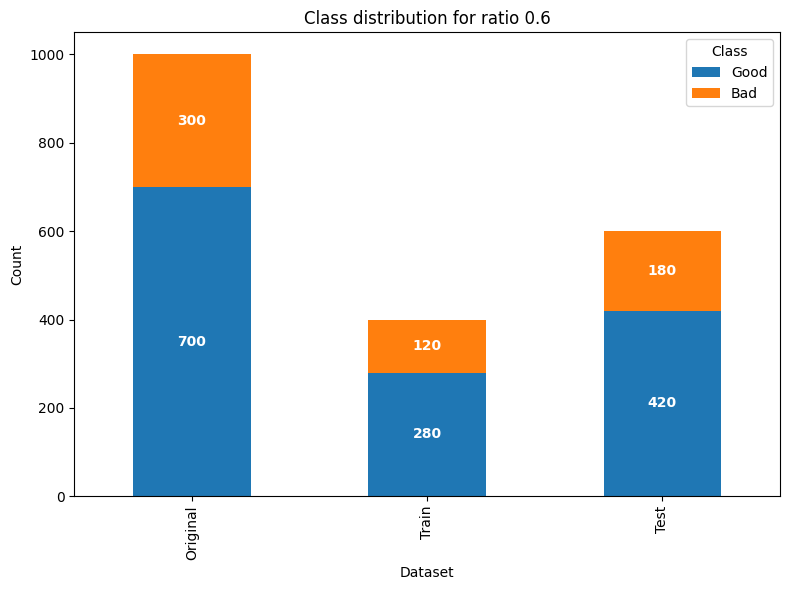


(process:22764): Pango-CRITICAL **: 11:00:06.324: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:22764): Pango-CRITICAL **: 11:00:06.324: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:22764): Pango-CRITICAL **: 11:00:06.324: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:22764): Pango-CRITICAL **: 11:00:06.324: pango_font_description_get_family: assertion 'desc != NULL' failed

Classification report!
              precision    recall  f1-score   support

           1       0.78      0.75      0.77       420
           2       0.46      0.50      0.48       180

    accuracy                           0.68       600
   macro avg       0.62      0.63      0.62       600
weighted avg       0.68      0.68      0.68       600

Confusion matrix!


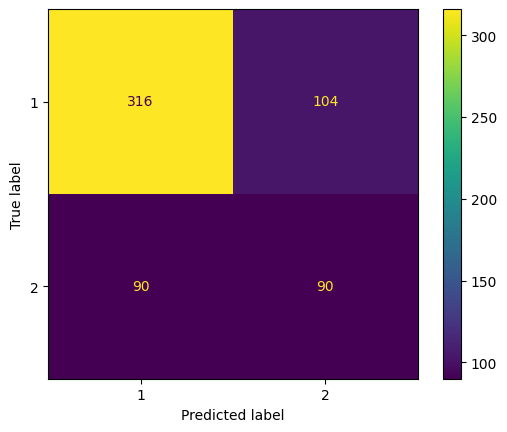

In [105]:
split_train_test(0.6, True)
id3_40_60 = build_id3('output/splits/statlog_german_credit/id3_statlog_40_60.png', None)
pred_40_60 = evaluate(id3_40_60, True)

# 5. 60/40 ratio for train/test set

Class distribution for test ratio = 0.4


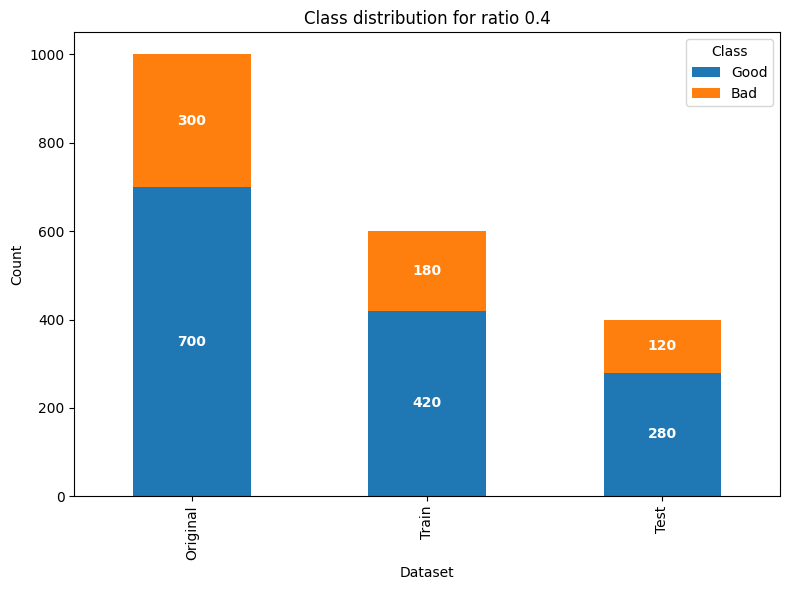


(process:656): Pango-CRITICAL **: 11:00:10.754: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:656): Pango-CRITICAL **: 11:00:10.754: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:656): Pango-CRITICAL **: 11:00:10.754: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:656): Pango-CRITICAL **: 11:00:10.754: pango_font_description_get_family: assertion 'desc != NULL' failed

Classification report!
              precision    recall  f1-score   support

           1       0.76      0.74      0.75       280
           2       0.43      0.46      0.44       120

    accuracy                           0.66       400
   macro avg       0.60      0.60      0.60       400
weighted avg       0.66      0.66      0.66       400

Confusion matrix!


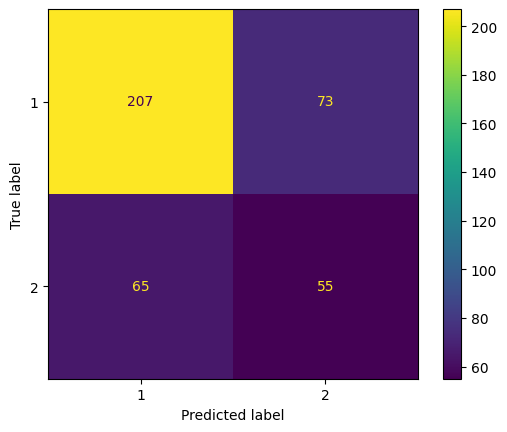

In [106]:
split_train_test(0.4, True)
id3_60_40 = build_id3('output/splits/statlog_german_credit/id3_statlog_60_40.png', None)
pred_60_40 = evaluate(id3_60_40, True)

# 6. 80/20 ratio for train/test set

Class distribution for test ratio = 0.2


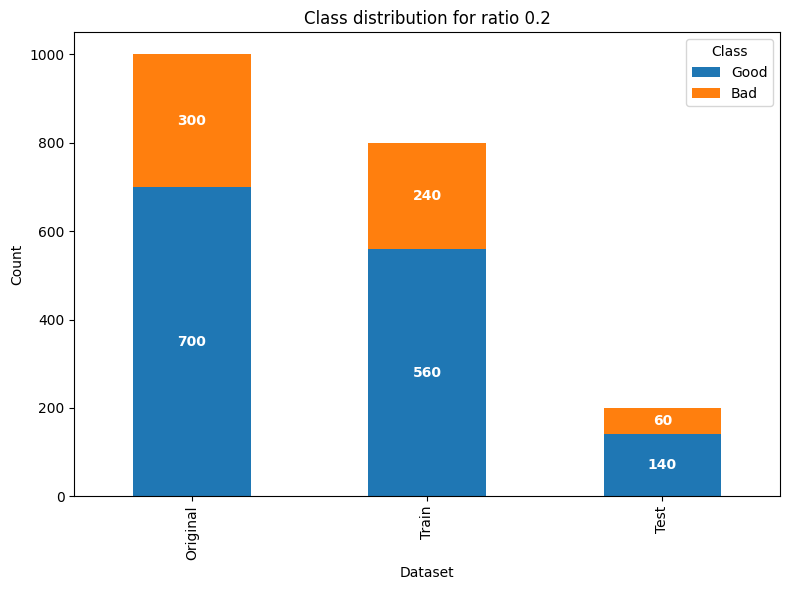


(process:21180): Pango-CRITICAL **: 11:00:15.537: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:21180): Pango-CRITICAL **: 11:00:15.537: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:21180): Pango-CRITICAL **: 11:00:15.537: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:21180): Pango-CRITICAL **: 11:00:15.537: pango_font_description_get_family: assertion 'desc != NULL' failed

Classification report!
              precision    recall  f1-score   support

           1       0.76      0.76      0.76       140
           2       0.45      0.45      0.45        60

    accuracy                           0.67       200
   macro avg       0.61      0.61      0.61       200
weighted avg       0.67      0.67      0.67       200

Confusion matrix!


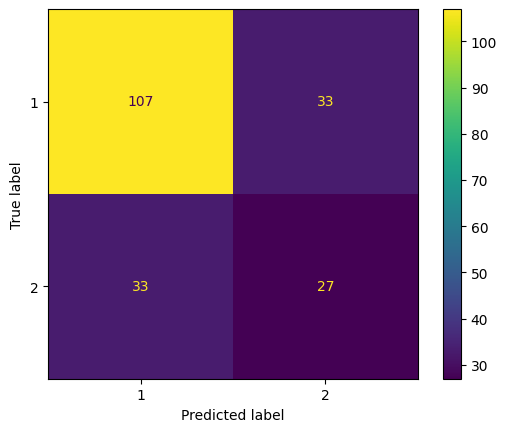

In [107]:
split_train_test(0.2, True)
id3_80_20 = build_id3('output/splits/statlog_german_credit/id3_statlog_80_20.png', None)
pred_80_20 = evaluate(id3_80_20, True)

# 7. 90/10 ratio for train/test set

Class distribution for test ratio = 0.1


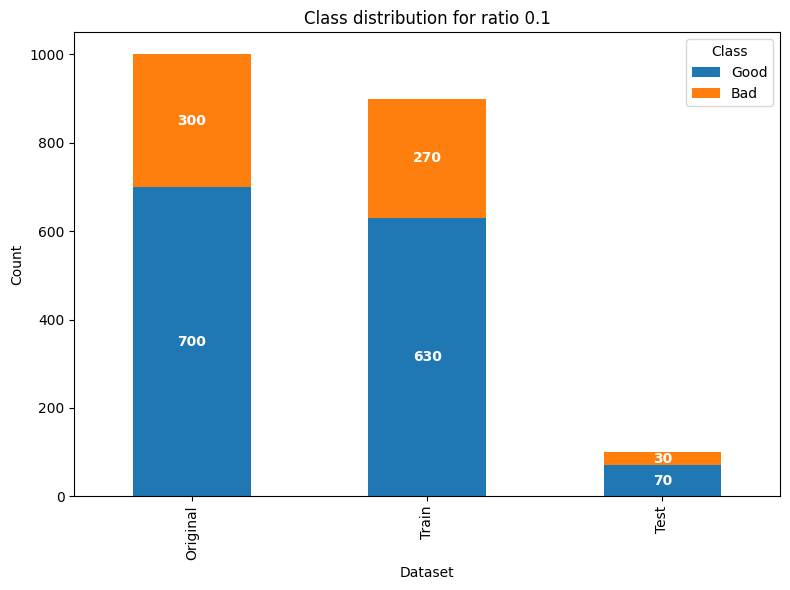


(process:14496): Pango-CRITICAL **: 11:00:20.662: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:14496): Pango-CRITICAL **: 11:00:20.662: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:14496): Pango-CRITICAL **: 11:00:20.662: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:14496): Pango-CRITICAL **: 11:00:20.662: pango_font_description_get_family: assertion 'desc != NULL' failed

Classification report!
              precision    recall  f1-score   support

           1       0.76      0.80      0.78        70
           2       0.46      0.40      0.43        30

    accuracy                           0.68       100
   macro avg       0.61      0.60      0.60       100
weighted avg       0.67      0.68      0.67       100

Confusion matrix!


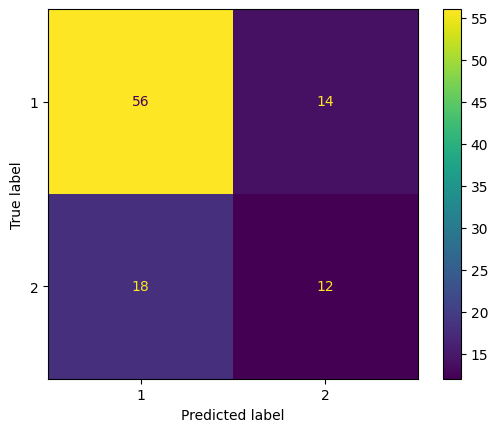

In [108]:
split_train_test(0.1, True)
id3_90_10 = build_id3('output/splits/statlog_german_credit/id3_statlog_90_10.png', None)
pred_90_10 = evaluate(id3_90_10, True)

# 8. The depth and accuracy of a decision tree
Only applied for 80/20 training and test sets only. This task will show how the depth of the decision tree affects the classification accuracy.

Depth = None


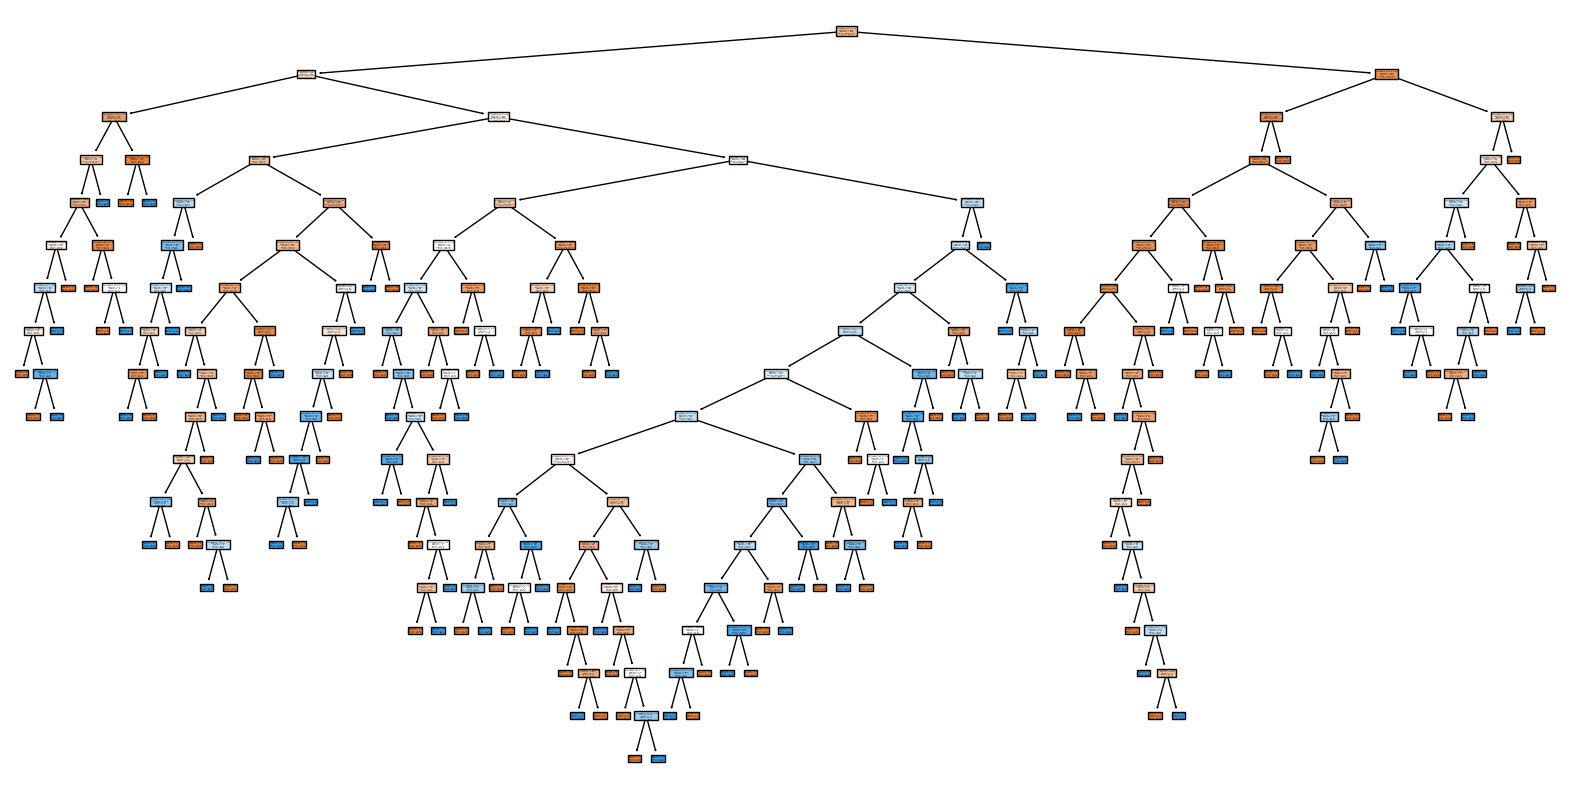

Depth = 2


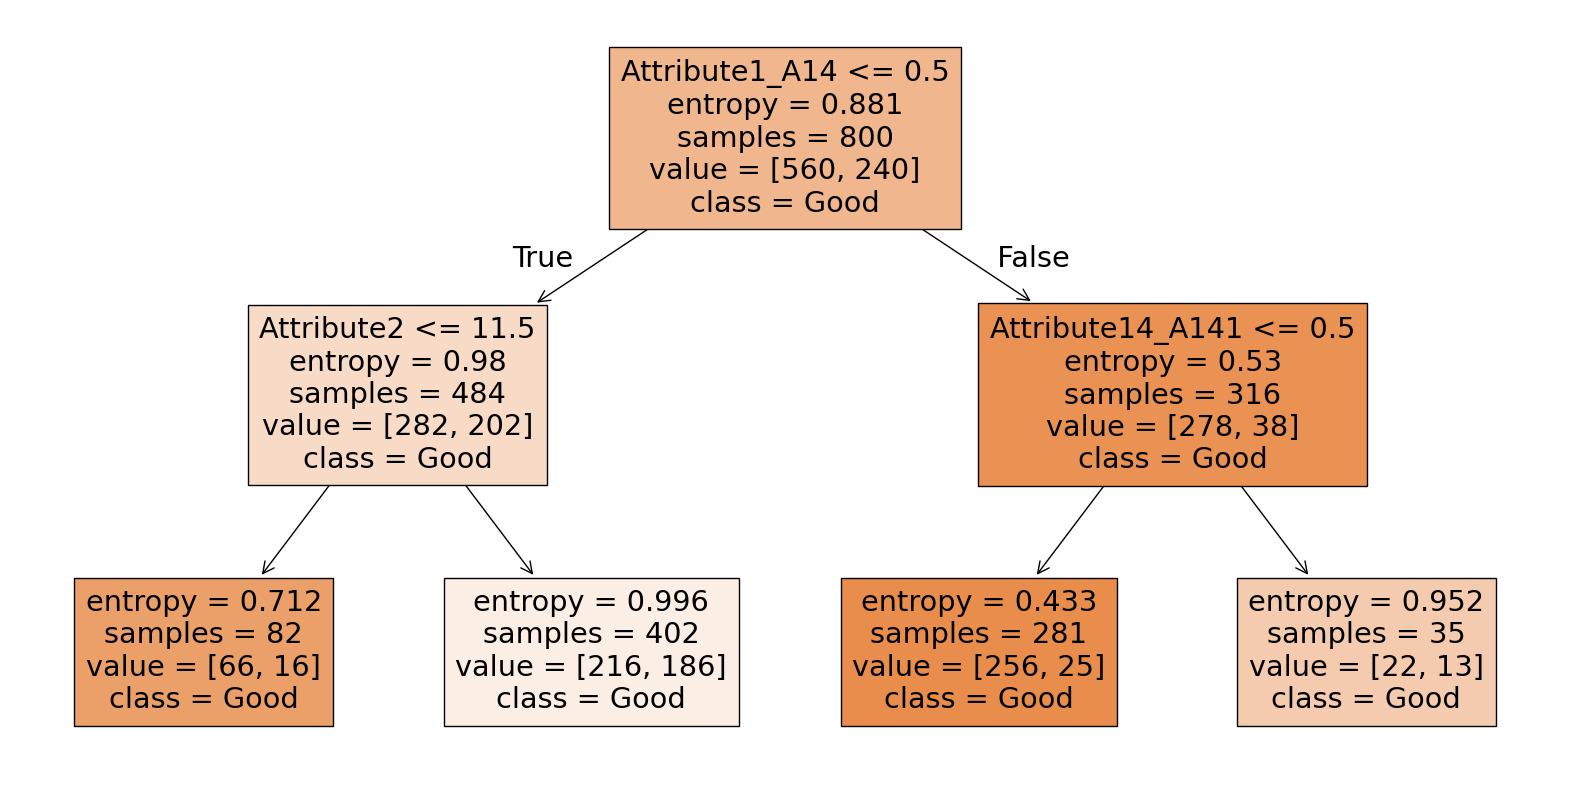

Depth = 3


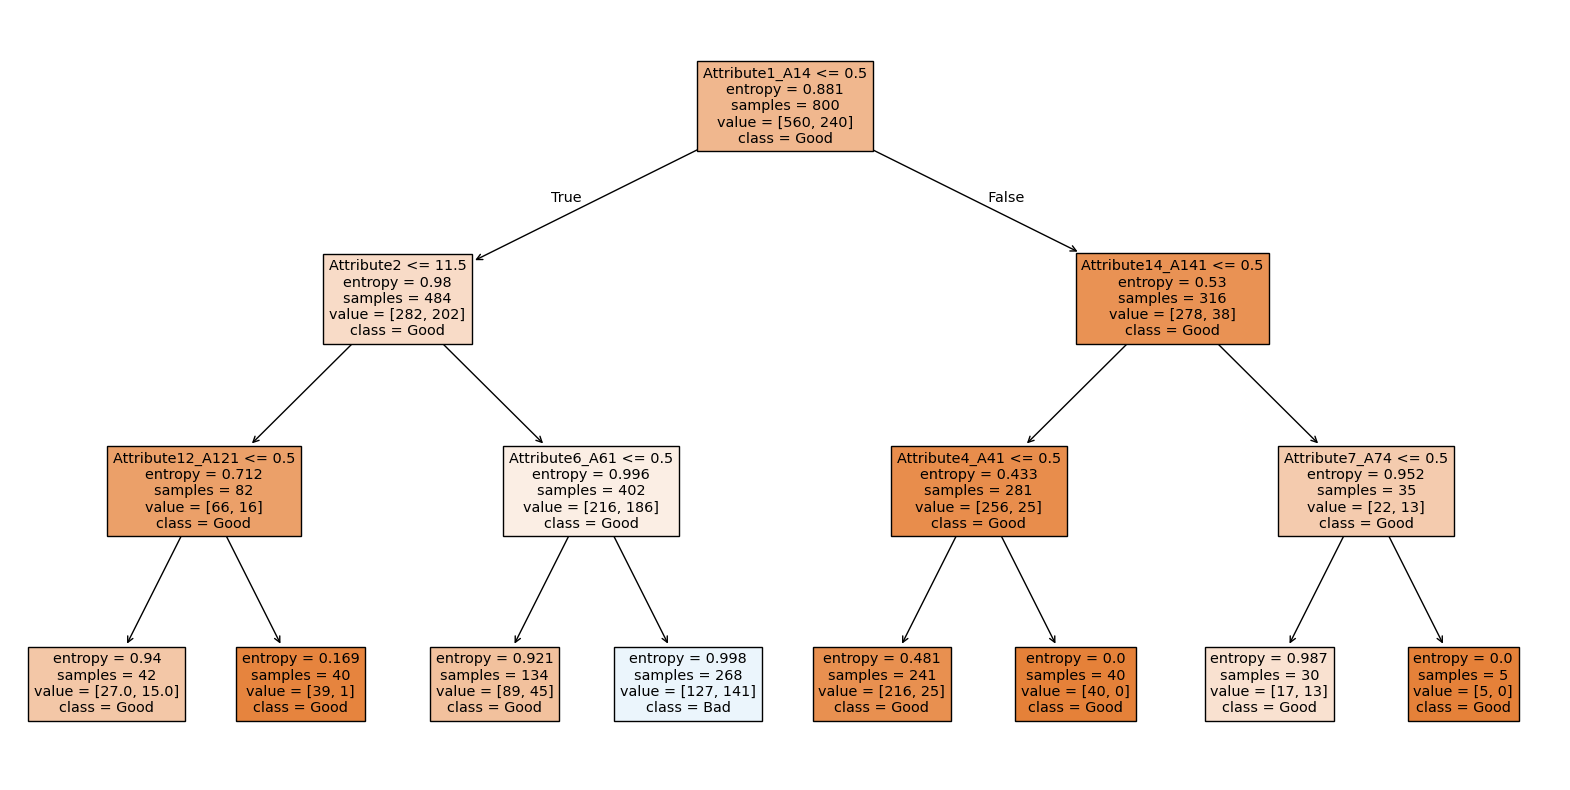

Depth = 4


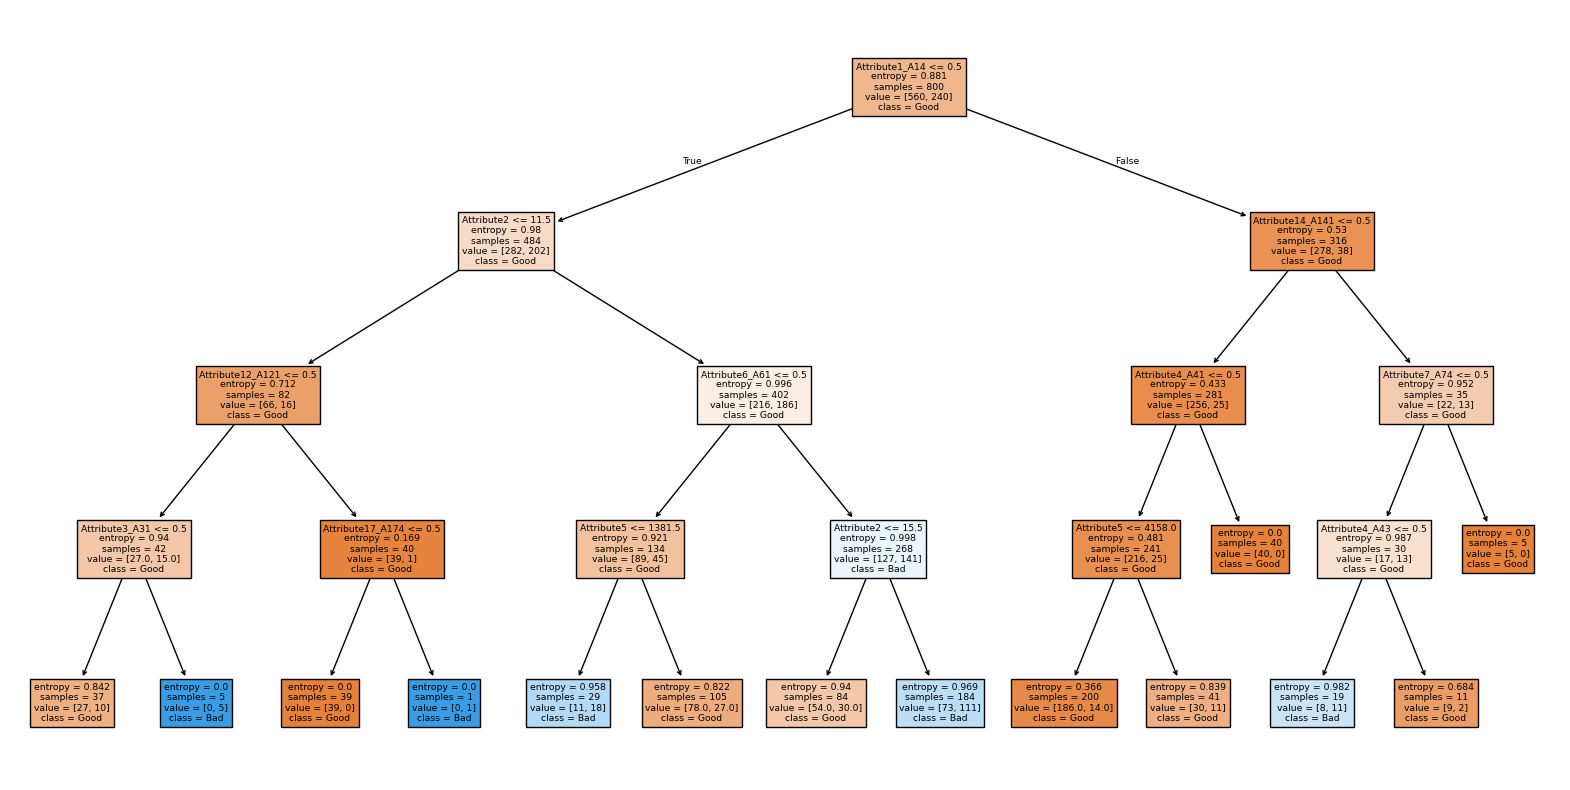

Depth = 5


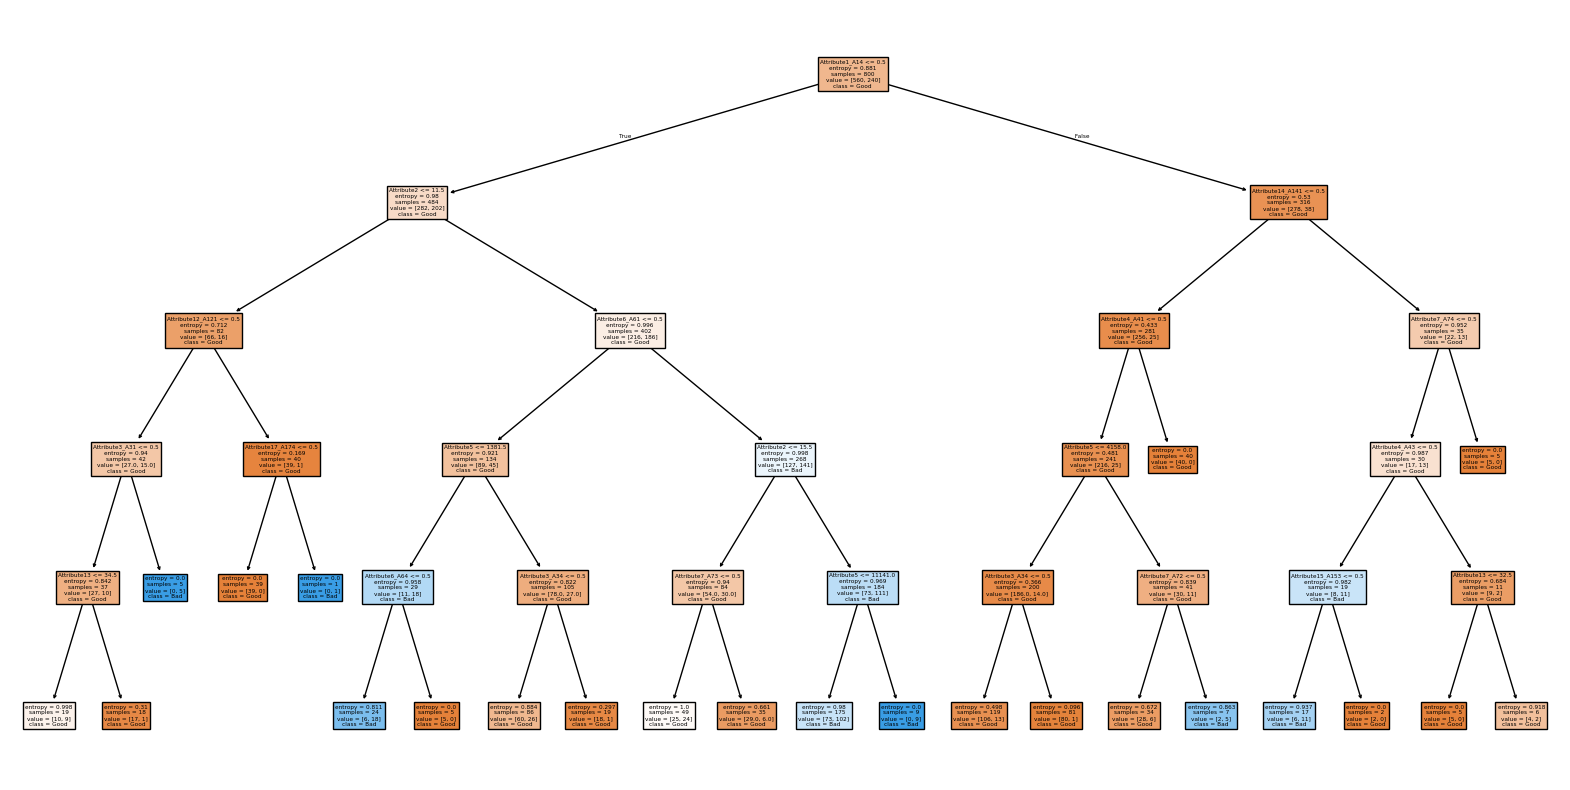

Depth = 6


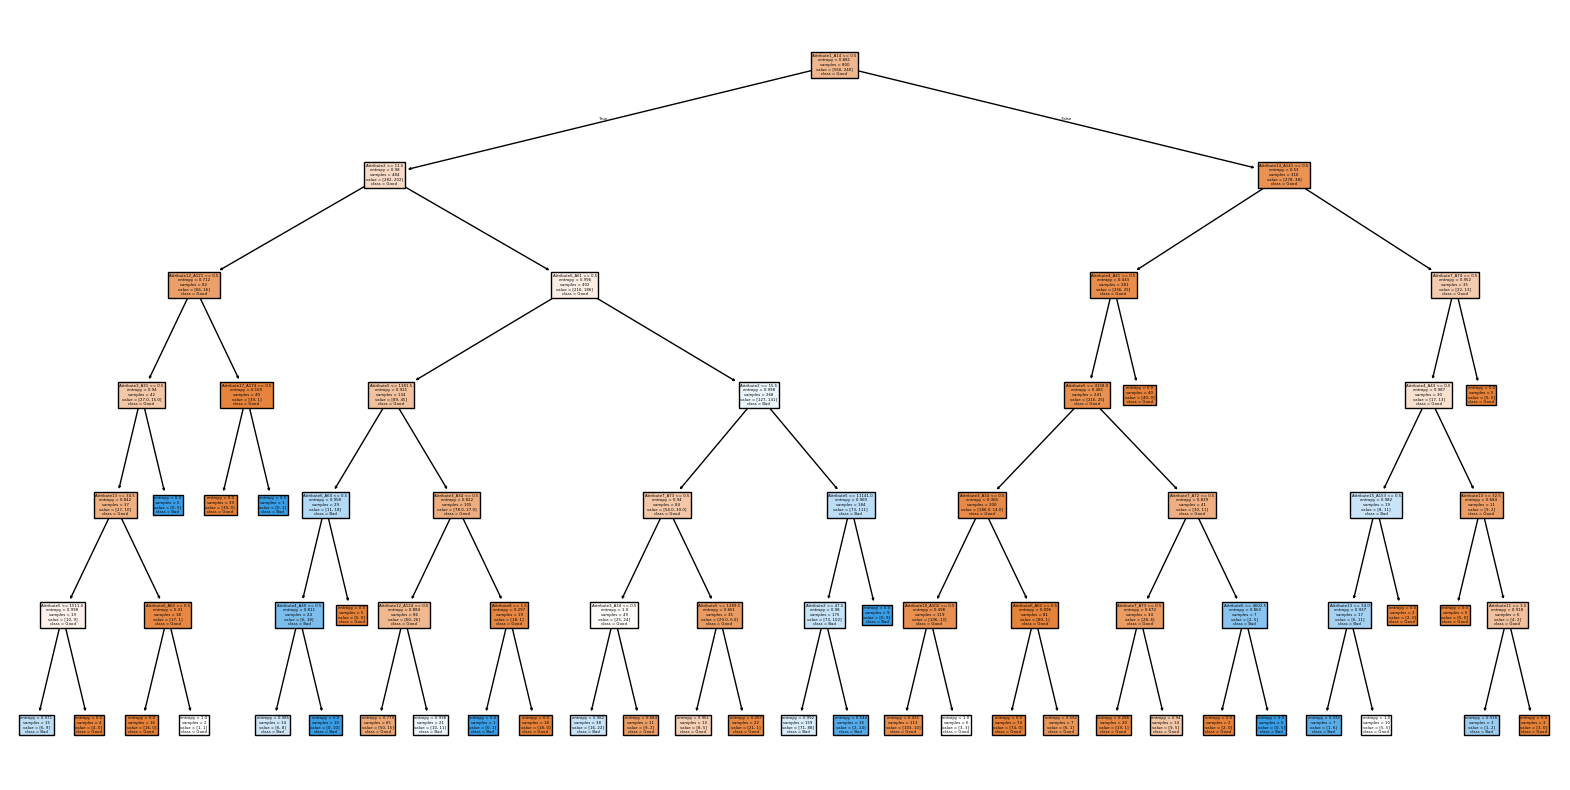

Depth = 7


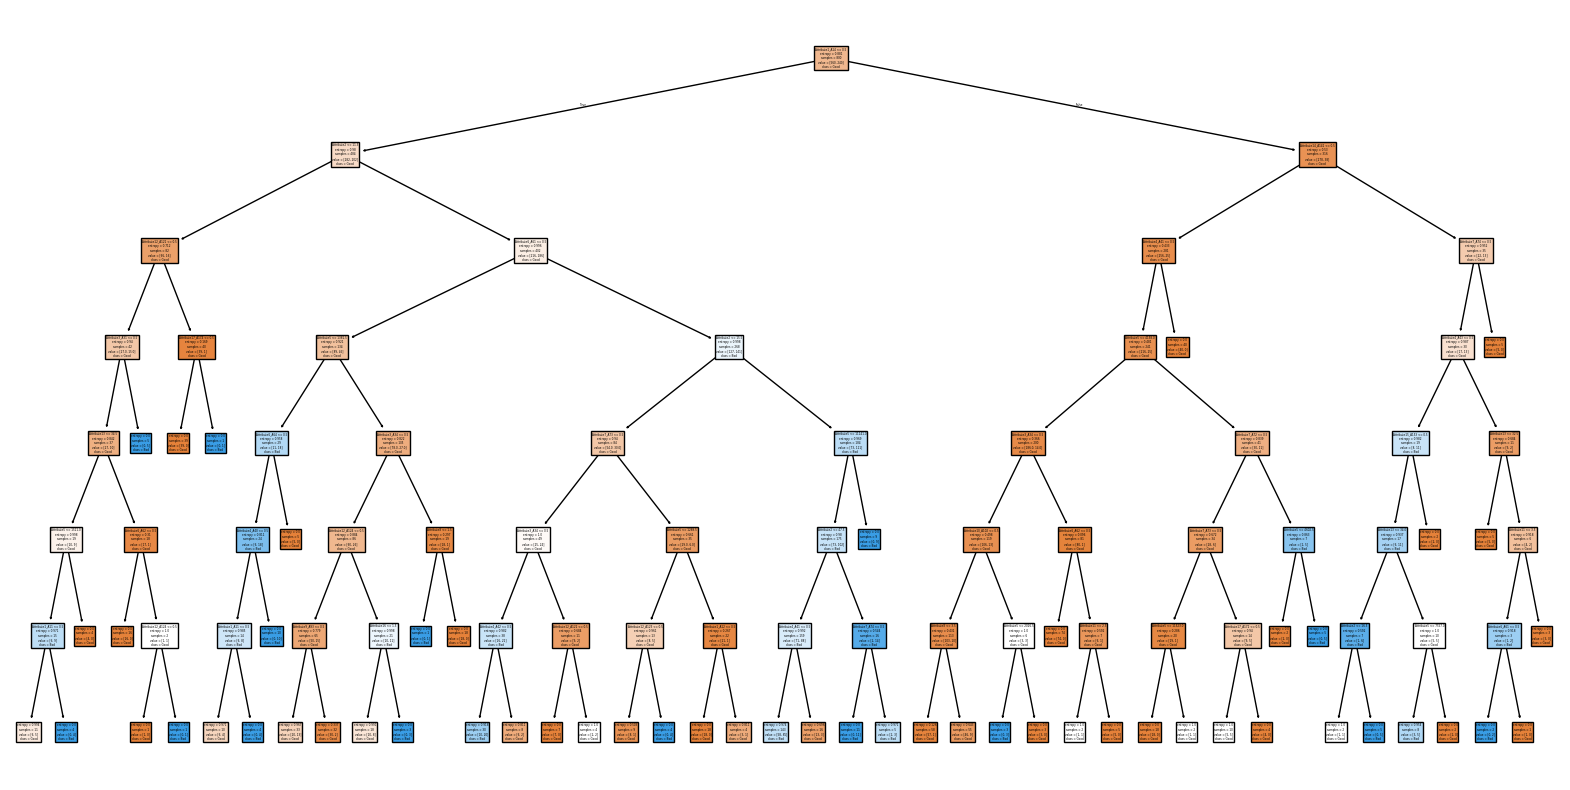

   max_depth  Accuracy
0        NaN     0.670
1        2.0     0.700
2        3.0     0.685
3        4.0     0.660
4        5.0     0.670
5        6.0     0.620
6        7.0     0.655


In [109]:
split_train_test(0.2, False)

depth_tests = [None, 2, 3, 4, 5, 6, 7]
accuracy = {}

for depth in depth_tests:
    id3 = build_id3(None, depth)
    predictions = evaluate(id3, False)
    accuracy[depth] = accuracy_score(label_test, predictions)

    # Visualize the tree with corresponding depth
    print("Depth =", depth)
    plt.figure(figsize=(20,10))
    tree.plot_tree(id3, feature_names=features_encoded.columns, class_names=["Good", "Bad"], filled=True)
    plt.show()

accuracy_table = pd.DataFrame({'max_depth': depth_tests,
                               'Accuracy': [accuracy[depth] for depth in depth_tests]}) 
print(accuracy_table)

# 8.1 Charts showing correlation between max depth and accuracy

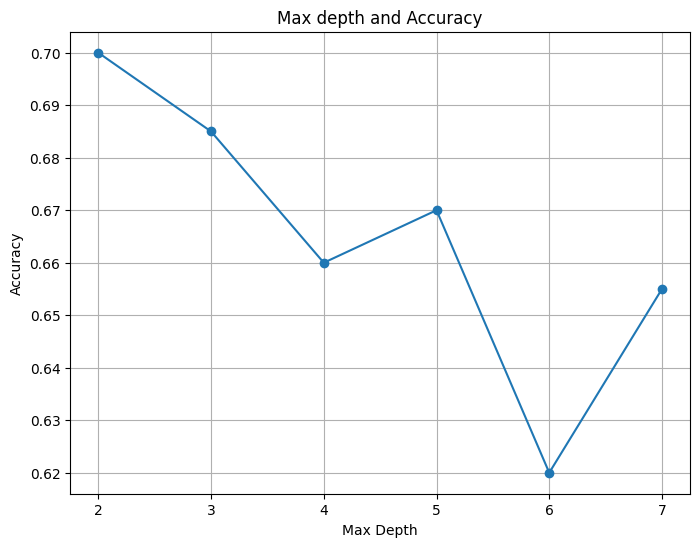

In [110]:
plt.figure(figsize=(8, 6))
plt.plot(depth_tests, [accuracy[depth] for depth in depth_tests], marker='o')
plt.title('Max depth and Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Looking at the chart, why did the overall accuracy gradually decreased as the max depth increases. This occurs due to the overfitting problem, when the decision-tree-learning algorithm will generate a large tree when there is actually no pattern to be found (cited from section 18.3.5 of Artificial Intelligence A Modern Approach - 3rd Edition). 
<br> The decision-tree-learning algorithm will seize on any pattern it can find in the input, thus, when receiving a completely new test set, the test accuracy drops. <br>
To combat overfitting, there is a technique called decision tree pruning, which eliminates nodes that are not clearly relevant. However, in this project, we won't deep diver into this.